In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as fsm
import statsmodels.api as sm
import scipy as sp
import pydotplus

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso,LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz  
from sklearn.externals.six import StringIO  
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold
from sklearn import preprocessing as PP
from yellowbrick.regressor import ResidualsPlot
from IPython.display import Image  
from keras import initializers as Itz
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from fancyimpute import KNN 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [2]:
ipoRawData = pd.read_excel('IPO_data.xlsx')

In [3]:
ipoData = ipoRawData.rename(columns={
    'Issuer Company': 'IssueComp',
    'Lot Size': 'LotSize',
    'Issue Price(Rs)': 'IssuePrice',
    'Issue Size (Rs Cr)': 'IssueSize',
    'Face Value (INR per share)': 'FaceValue',
    'Latest Revenue (INR in Lakh)': 'LastRevenue',
    'Net Asset Value (NAV) (INR per share)': 'NAV',
    'Issue Type': 'IssueType',
    'Earning Per Share (EPS)(INR)': 'EPS',
    'Price Per Earning (P/E ratio)': 'PERatio',
    'Return on NetWorth (RONW)(in %)': 'RONW',
    'Issue open for (Days)': 'DaysOpen',
    'Subscription Ratio': 'SubRatio',
    'Is Mainboard IPO': 'IsMain',
    'Listing Day Close Price (Rs)': 'ClosePrice'
})

In [ ]:
ipoData.info()

In [ ]:
#Missing value check
ipoData.isnull().sum()

In [4]:
#Missing value treatment
#Drop missing EPS records
ipoData=ipoData.dropna(subset=['EPS'])

# Convert unit of issue size from Crores
ipoData.IssueSize = [x*10000000 for x in ipoData.IssueSize]

# Add number of shares column
ipoData['Shares'] = [x/y for x,y in zip(ipoData.IssueSize, ipoData.IssuePrice)]

#Compute missing PE ratio
ipoData.PERatio = [y/z if np.isnan(x) else x for x, y, z in zip(ipoData.PERatio, ipoData.IssuePrice, ipoData.EPS)]

# Convert unit of issue size from Crores
ipoData.LastRevenue = [x*100000 for x in ipoData.LastRevenue]

#Compute missing RONW
ipoData.RONW = [y/z if np.isnan(x) else x for x, y, z in zip(ipoData.RONW, ipoData.LastRevenue, ipoData.IssueSize)]

In [ ]:
print("Issue Type for Mainboard IPO")
ipoData[ipoData.IsMain == 1].IssueType.value_counts()

In [ ]:
print("Issue Type for SME IPO")
ipoData[ipoData.IsMain == 0].IssueType.value_counts()

In [5]:
#Dummy Code Issue Types
ipoDataDummied = pd.get_dummies(ipoData, columns = ['IssueType'])

In [6]:
ipoDataDummied = ipoDataDummied.rename(columns = {
    'IssueType_Book Built Issue IPO': 'BBIIPO',
    'IssueType_Fixed Price Issue IPO': 'FPIIPO'
})

In [42]:
smeData = ipoDataDummied[ipoDataDummied.IsMain == 0]
mainData = ipoDataDummied[ipoDataDummied.IsMain == 1]
print("------------SME IPO Information-------------")
print(smeData.info())

print("------------MainBoard IPO Information-------------")
print(mainData.info())

------------SME IPO Information-------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 524 entries, 0 to 666
Data columns (total 20 columns):
IssueComp      524 non-null object
Exchange       524 non-null object
Open           524 non-null datetime64[ns]
Close          524 non-null datetime64[ns]
LotSize        524 non-null int64
IssuePrice     524 non-null int64
IssueSize      524 non-null float64
FaceValue      524 non-null int64
LastRevenue    524 non-null float64
NAV            524 non-null float64
EPS            524 non-null float64
PERatio        524 non-null float64
RONW           524 non-null float64
DaysOpen       524 non-null int64
SubRatio       524 non-null float64
IsMain         524 non-null int64
ClosePrice     524 non-null float64
Shares         524 non-null float64
BBIIPO         524 non-null uint8
FPIIPO         524 non-null uint8
dtypes: datetime64[ns](2), float64(9), int64(5), object(2), uint8(2)
memory usage: 78.8+ KB
None
------------MainBoard IPO Informati

In [ ]:
#colsToIgnore = ['IssueComp', 'Exchange', 'Open', 'Close', 'IssueType']
#colsNumeric = list(set(ipoData)  - set(colsToIgnore))
# ipoDataImputed = pd.DataFrame(KNN(k = 5).fit_transform(ipoData[colsNumeric]), columns = colsNumeric)
# ipoDataImputed.info()

In [ ]:
#ipoDataDummied.columns

In [ ]:
print('-------------------------SME IPO Description-----------------')
desCols = ['LotSize', 'IssuePrice', 'IssueSize', 'FaceValue', 'SubRatio', 'DaysOpen', 'ClosePrice']
smeData[desCols].describe()

In [ ]:
smeData[smeData.columns.difference(desCols)].describe()

In [ ]:
print('-------------------------MainBoard IPO Description-----------------')
mainData[desCols].describe()

In [ ]:
mainData[mainData.columns.difference(desCols)].describe()

In [ ]:
smeData.head()

In [ ]:
smeData.tail()

In [ ]:
mainData.head()

In [ ]:
mainData.tail()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.ClosePrice, ax = ax[0]).set_title("SME IPO - Listing day Close Price - Histogram")
sns.boxplot(smeData.ClosePrice, ax = ax[1]).set_title("SME IPO - Listing day Close Price - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssuePrice, ax = ax[0]).set_title("SME IPO - Issue Price - Histogram")
sns.boxplot(smeData.IssuePrice, ax = ax[1]).set_title("SME IPO - Issue Price - Box Plot")

In [ ]:
# Any SME IPO record with issue price greater than 300 is being discard from analysis as it is significant outlier
smeData=smeData[smeData.IssuePrice <= 300]
smeData.IssuePrice.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.ClosePrice, ax = ax[0]).set_title("Mainboard IPO - Listing day Close Price - Histogram")
sns.boxplot(mainData.ClosePrice, ax = ax[1]).set_title("Mainboard IPO - Listing day Close Price - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssuePrice, ax = ax[0]).set_title("Mainboard IPO - Issue Price - Histogram")
sns.boxplot(mainData.IssuePrice, ax = ax[1]).set_title("Mainboard IPO - Issue Price - Box Plot")

In [ ]:
# Main Board IPO record with issue price greater than 1200 is being discarded from analysis as it is significant outlier
mainData=mainData[mainData.IssuePrice <= 1200]
mainData.IssuePrice.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LotSize, ax = ax[0]).set_title("SME IPO - Lot Size - Histogram")
sns.boxplot(smeData.LotSize, ax = ax[1]).set_title("SME IPO - Lot Size - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LotSize, ax = ax[0]).set_title("MainBoard IPO - Lot Size - Histogram")
sns.boxplot(mainData.LotSize, ax = ax[1]).set_title("MainBoard IPO - Lot Size - Box Plot")

In [ ]:
# Main Board IPO record with Lot Size greater than 400 is being discarded from analysis as it is significant outlier
mainData=mainData[mainData.LotSize <= 400]
mainData.LotSize.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.IssueSize, ax = ax[0]).set_title("SME IPO - Issue Size - Histogram")
sns.boxplot(smeData.IssueSize, ax = ax[1]).set_title("SME IPO - Issue Size - Box Plot")

In [ ]:
smeData.IssueSize.describe()

In [ ]:
# Any SME IPO record with issue size greater than INR 60 Cr is being discard from analysis as it is significant outlier
smeData=smeData[smeData.IssueSize <= 600000000]
smeData.IssueSize.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.IssueSize, ax = ax[0]).set_title("MainBoard IPO - Issue Size - Histogram")
sns.boxplot(mainData.IssueSize, ax = ax[1]).set_title("MainBoard IPO - Issue Size - Box Plot")

In [ ]:
mainData.IssueSize.describe()

In [ ]:
# Any Main IPO record with issue size greater than INR 8000 Cr is being discard from analysis as it is significant outlier
mainData=mainData[mainData.IssueSize <= 80000000000]
mainData.IssueSize.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.LastRevenue, ax = ax[0]).set_title("SME IPO - Last Yearly Revenue - Histogram")
sns.boxplot(smeData.LastRevenue, ax = ax[1]).set_title("SME IPO - Last Yearly Revenue - Box Plot")

In [ ]:
# Any SME IPO record with last yearly revenue greater than INR 2000 Cr is being discard from analysis as it is significant outlier
smeData=smeData[smeData.LastRevenue <= 20000000000]
smeData.LastRevenue.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.LastRevenue, ax = ax[0]).set_title("MainBoard IPO - Last Yearly Revenue - Histogram")
sns.boxplot(mainData.LastRevenue, ax = ax[1]).set_title("MainBoard - Last Yearly Revenue - Box Plot")

In [ ]:
# Any Mainboard IPO record with last yearly revenue greater than INR 10000 Cr is being discard from analysis as it is significant outlier
mainData=mainData[mainData.LastRevenue <= 100000000000]
mainData.LastRevenue.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.NAV, ax = ax[0]).set_title("SME IPO - Net Asset Value - Histogram")
sns.boxplot(smeData.NAV, ax = ax[1]).set_title("SME IPO - Net Asset Value - Box Plot")

In [ ]:
# Any SME IPO record with net asset value per share greater than INR 500 is being discard from analysis as it is significant outlier
smeData=smeData[smeData.NAV <= 500]
smeData.NAV.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.NAV, ax = ax[0]).set_title("MainBoard IPO - Net Asset Value - Histogram")
sns.boxplot(mainData.NAV, ax = ax[1]).set_title("MainBoard IPO - Net Asset Value - Box Plot")

In [ ]:
# Any Main IPO record with net asset value per share greater than INR 500 is being discard from analysis as it is significant outlier
mainData=mainData[mainData.NAV <= 500]
mainData.NAV.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.EPS, ax = ax[0]).set_title("SME IPO - Earnings Per Share - Histogram")
sns.boxplot(smeData.EPS, ax = ax[1]).set_title("SME IPO - Earnings Per Share - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.EPS, ax = ax[0]).set_title("MainBoard IPO - Earnings Per Share - Histogram")
sns.boxplot(mainData.EPS, ax = ax[1]).set_title("MainBoard IPO - Earnings Per Share - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.PERatio, ax = ax[0]).set_title("SME IPO - PE Ratio - Histogram")
sns.boxplot(smeData.PERatio, ax = ax[1]).set_title("SME IPO - PE Ratio - Box Plot")

In [ ]:
# Any SME IPO record with P/E Ratio greater than INR 2000 & less than -2000 is being discard from analysis as it is significant outlier
smeData=smeData[smeData.PERatio <= 2000 ]
smeData=smeData[smeData.PERatio > -2000 ]
smeData.PERatio.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.PERatio, ax = ax[0]).set_title("MainBoard IPO - PE Ratio - Histogram")
sns.boxplot(mainData.PERatio, ax = ax[1]).set_title("MainBoard IPO - PE Ratio - Box Plot")

In [ ]:
# Any Main IPO record with PE ratio greater than INR 2500 is being discard from analysis as it is significant outlier
mainData=mainData[mainData.PERatio <= 2500]
mainData.PERatio.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.RONW, ax = ax[0]).set_title("SME IPO - Return on networth - Histogram")
sns.boxplot(smeData.RONW, ax = ax[1]).set_title("SME IPO - Return on networth - Box Plot")

In [ ]:
# Any SME IPO record with P/E Ratio greater than INR 100 & less than -100 is being discard from analysis as it is significant outlier
smeData=smeData[smeData.RONW <= 100 ]
smeData=smeData[smeData.RONW > -100 ]
smeData.RONW.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.RONW, ax = ax[0]).set_title("MainBoard IPO - Return on networth - Histogram")
sns.boxplot(mainData.RONW, ax = ax[1]).set_title("MainBoard IPO - Return on networth - Box Plot")

In [ ]:
# Any Mainboard IPO record with RONW greater than INR 1000  is being discard from analysis as it is significant outlier
mainData=mainData[mainData.RONW <= 1000 ]
mainData.RONW.describe()

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.SubRatio, ax = ax[0]).set_title("SME IPO - Subscription Ratio - Histogram")
sns.boxplot(smeData.SubRatio, ax = ax[1]).set_title("SME IPO - Subscription Ratio - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.SubRatio, ax = ax[0]).set_title("MainBoard IPO - Subscription Ratio - Histogram")
sns.boxplot(mainData.SubRatio, ax = ax[1]).set_title("MainBoard IPO - Subscription Ratio - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(smeData.DaysOpen, ax = ax[0]).set_title("SME IPO - Days Open - Histogram")
sns.boxplot(smeData.DaysOpen, ax = ax[1]).set_title("SME IPO - Days Open - Box Plot")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
sns.distplot(mainData.DaysOpen, ax = ax[0]).set_title("MainBoard IPO - Days Open - Histogram")
sns.boxplot(mainData.DaysOpen, ax = ax[1]).set_title("MainBoard IPO - Days Open - Box Plot")

In [8]:
colsNumeric = ['ClosePrice', 'IssuePrice', 'LotSize', 'IssueSize', 'LastRevenue','NAV','EPS','PERatio','RONW','SubRatio','DaysOpen']
colsToCorrelate = colsNumeric
smeCorr = smeData[colsToCorrelate].corr()
mainCorr = mainData[colsToCorrelate].corr()

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(smeCorr,cmap='BrBG',annot=True, center = 0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(mainCorr,cmap='BrBG',annot=True, center = 0)

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Issue Price Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssuePrice, plData.ClosePrice)
ax.set_xlabel('Issue Price')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Issue Price Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Lot Size Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LotSize, plData.ClosePrice)
ax.set_xlabel('Lot Size')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Lot Size Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size (INR)')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Issue Size Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.IssueSize, plData.ClosePrice)
ax.set_xlabel('Issue Size (INR)')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Issue Size Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Last Yearly Revenue')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Last Yearly Revenue Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.LastRevenue, plData.ClosePrice)
ax.set_xlabel('Last Yearly Revenue')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Last Yearly Revenue Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.PERatio, plData.ClosePrice)
ax.set_xlabel('Price to Earnings Ratio')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Price to Earnings Ratio Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Days Open Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.DaysOpen, plData.ClosePrice)
ax.set_xlabel('Days Open')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Days Open Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Subscription Ratio Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.SubRatio, plData.ClosePrice)
ax.set_xlabel('Subscription Ratio')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Subscription Ratio Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('SME Data - Earnings Per Share Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.EPS, plData.ClosePrice)
ax.set_xlabel('Earnings Per Share')
ax.set_ylabel('Listing Day Close Price (Rupees)')
plt.title('MainBoard Data - Earnings Per Share Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Net Asset Value per share Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.NAV, plData.ClosePrice)
ax.set_xlabel('Net Asset Value')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Net Asset Value per share Vs Close Price')
plt.show()

In [ ]:
plData = smeData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Return on networth per share')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('SME Data - Return on networth per share Vs Close Price')
plt.show()

In [ ]:
plData = mainData
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(plData.RONW, plData.ClosePrice)
ax.set_xlabel('Return on networth per share')
ax.set_ylabel('Listing Day Close Price (INR)')
plt.title('MainBoard Data - Return on networth per share Vs Close Price')
plt.show()

In [ ]:
#Split Train & Test
y = smeData.ClosePrice
x = smeData
x = x.drop('ClosePrice',axis=1)
x = x.drop('IssueComp',axis=1)
x = x.drop('Open',axis=1)
x = x.drop('Close',axis=1)
x = x.drop('Exchange',axis=1)
x = x.drop('Shares',axis=1)
x = x.drop('IsMain',axis=1)
x = x.drop('FaceValue',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

x.head()

In [ ]:
# Lasso
# Since we have a lot of outliers in the data we would go for Lasso regression which is robust to Outliers effect
#Initializing the Lasso Regressor with Normalization Factor as True
lasso_reg = Lasso(normalize=True)

#Fitting the Training data to the Lasso regressor
lasso_reg.fit(x_train,y_train)

mean_squared_error(y_test, lasso_reg.predict(x_test))

lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(x_train, y_train)

lasso_reg.set_params(alpha=lassocv.alpha_)
lasso_reg.fit(x_train, y_train)
mean_squared_error(y_test, lasso_reg.predict(x_test))



In [ ]:
#prediction and model evaluation for LASSO
y_train_pred = lasso_reg.predict(x_train)

dt_MSE = mean_squared_error(y_train, y_train_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_train, y_train_pred)
dt_MAPE = dt_MAE/len(y_train)
    
print('Mean Squared Error(Train): ', dt_MSE)
print('Root Mean Squared Error(Train): ', dt_RMSE)
print('Mean Absolute Error(Train): ', dt_MAE)
print('Mean Absolute Percentage Error(Train): ', dt_MAPE)

y_test_pred = lasso_reg.predict(x_test)

dt_MSE = mean_squared_error(y_test, y_test_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_test, y_test_pred)
dt_MAPE = dt_MAE/len(y_test)
    
print('Mean Squared Error(Test): ', dt_MSE)
print('Root Mean Squared Error(Test): ', dt_RMSE)
print('Mean Absolute Error(Test): ', dt_MAE)
print('Mean Absolute Percentage Error(Test): ', dt_MAPE)

In [ ]:
print('Intercept: ', lasso_reg.intercept_)
print('Coefficients: ', lasso_reg.coef_)

In [ ]:
# Residual check
visualizer = ResidualsPlot(lasso_reg)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show()            

In [ ]:
#Actual vs Predicted in Train
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(y_train_pred)+1)]
y1 = y_train
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = y_train_pred
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing day Close Price')
# Set a title of the current axes.
plt.title('Lasso - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
#Actual vs Predicted in Test
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(y_test_pred)+1)]
y1 = y_test
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = y_test_pred
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing day Close Price')
# Set a title of the current axes.
plt.title('Lasso - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
# CART Regression
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0,max_depth=7)  
  
# fit the regressor with X and Y data 
regressor.fit(x_train, y_train) 



In [ ]:
#prediction and model evaluation for CART
y_train_pred = regressor.predict(x_train)

dt_MSE = mean_squared_error(y_train, y_train_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_train, y_train_pred)
dt_MAPE = dt_MAE/len(y_train)
    
print('Mean Squared Error(Train): ', dt_MSE)
print('Root Mean Squared Error(Train): ', dt_RMSE)
print('Mean Absolute Error(Train): ', dt_MAE)
print('Mean Absolute Percentage Error(Train): ', dt_MAPE)

y_test_pred = regressor.predict(x_test)

dt_MSE = mean_squared_error(y_test, y_test_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_test, y_test_pred)
dt_MAPE = dt_MAE/len(y_test)
    
print('Mean Squared Error(Test): ', dt_MSE)
print('Root Mean Squared Error(Test): ', dt_RMSE)
print('Mean Absolute Error(Test): ', dt_MAE)
print('Mean Absolute Percentage Error(Test): ', dt_MAPE)

In [ ]:
#Plot regression tree
dot_data = StringIO()
export_graphviz(regressor, out_file =dot_data,
                filled=True,rounded=True,special_characters=True,
                feature_names =x.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Tree.png')
Image(graph.create_png())

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [ ]:
#Actual vs Predicted in Train
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(y_train_pred)+1)]
y1 = y_train
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = y_train_pred
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing day Close Price')
# Set a title of the current axes.
plt.title('CART - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
#Actual vs Predicted in Test
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(y_test_pred)+1)]
y1 = y_test
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = y_test_pred
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing day Close Price')
# Set a title of the current axes.
plt.title('CART - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
#Split Train & Test
y = smeData.Returns
x = smeData.drop('ClosePrice',axis=1)
x = x.drop('Returns',axis=1)
x = x.drop('IssueComp',axis=1)
x = x.drop('Open',axis=1)
x = x.drop('Close',axis=1)
x = x.drop('Exchange',axis=1)
x = x.drop('Shares',axis=1)
x = x.drop('IsMain',axis=1)
x = x.drop('FaceValue',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

x.head()

In [ ]:
# RF Regression
# create a regressor object 
rf = RandomForestRegressor(n_estimators = 1001, random_state = 0)  
  
# fit the regressor with X and Y data 
rf.fit(x_train, y_train) 

In [ ]:
#prediction and model evaluation for RF
y_train_pred = rf.predict(x_train)

dt_MSE = mean_squared_error(y_train, y_train_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_train, y_train_pred)
dt_MAPE = dt_MAE/len(y_train)
    
print('Mean Squared Error(Train): ', dt_MSE)
print('Root Mean Squared Error(Train): ', dt_RMSE)
print('Mean Absolute Error(Train): ', dt_MAE)
print('Mean Absolute Percentage Error(Train): ', dt_MAPE)

y_test_pred = rf.predict(x_test)

dt_MSE = mean_squared_error(y_test, y_test_pred)
dt_RMSE = math.sqrt(dt_MSE)
dt_MAE = mean_absolute_error(y_test, y_test_pred)
dt_MAPE = dt_MAE/len(y_test)
    
print('Mean Squared Error(Test): ', dt_MSE)
print('Root Mean Squared Error(Test): ', dt_RMSE)
print('Mean Absolute Error(Test): ', dt_MAE)
print('Mean Absolute Percentage Error(Test): ', dt_MAPE)



In [84]:
def getVif(dFrame):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(dFrame.values, i) for i in range(dFrame.shape[1])]
    vif["features"] = dFrame.columns
    return vif

In [71]:
def transformBoxCox(dFrame, colsToIgnore = [], konst = 100):
    tFrame = dFrame.copy()
    for col in dFrame.columns.difference(colsToIgnore):
        minValue = min(tFrame[col])
        if(minValue <= 0):
            tFrame[col] = [(x - minValue) + konst for x in dFrame[col]]
        tFrame[col] = sp.stats.boxcox(tFrame[col])[0] #Ignoring the lambda for max log likelihood.
    return tFrame

In [80]:
def plotBoxPlotFrame(dFrame, colsToPlot = []):
    for col in colsToPlot:
        fig, ax = plt.subplots(1,2,figsize=(15,8))
        sns.distplot(dFrame[col], ax = ax[0]).set_title("{} - Histogram".format(col))
        sns.boxplot(dFrame[col], ax = ax[1]).set_title("{} - Box Plot".format(col))

In [74]:
colsToIgnore = ipoDataDummied.columns.difference(colsNumeric)
smeDataBoxCox = transformBoxCox(smeData, colsToIgnore)
mainDataBoxCox = transformBoxCox(mainData, colsToIgnore)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


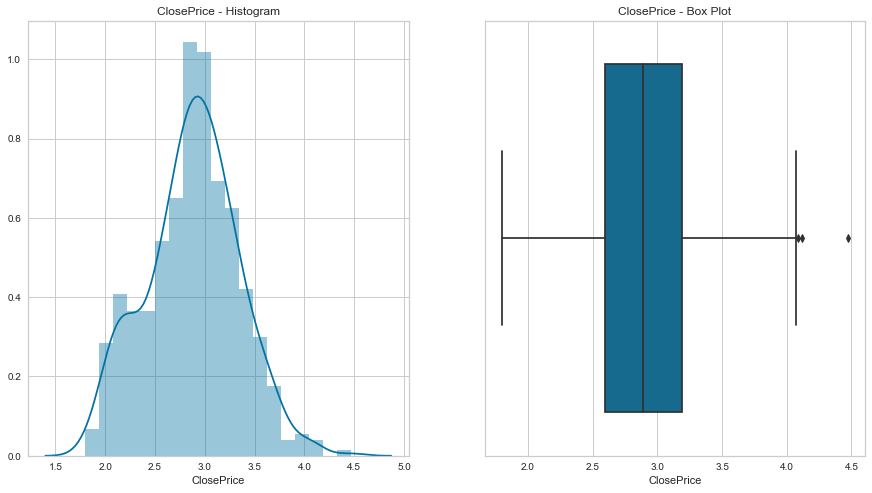

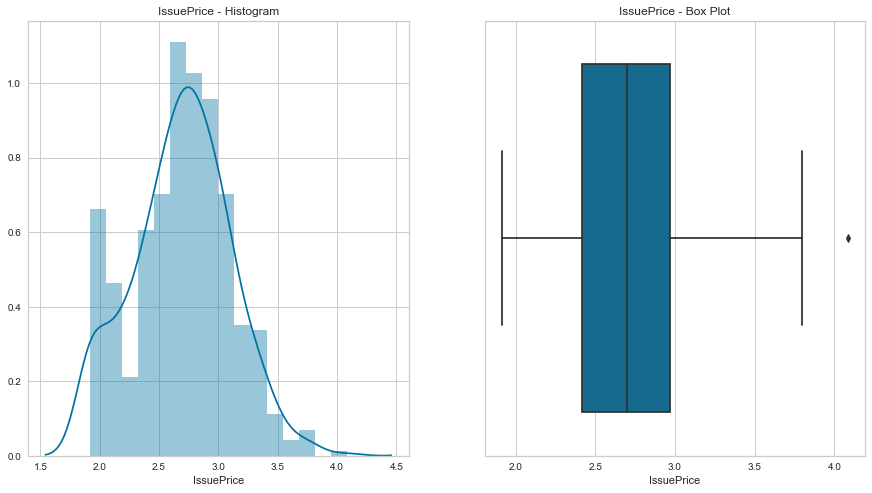

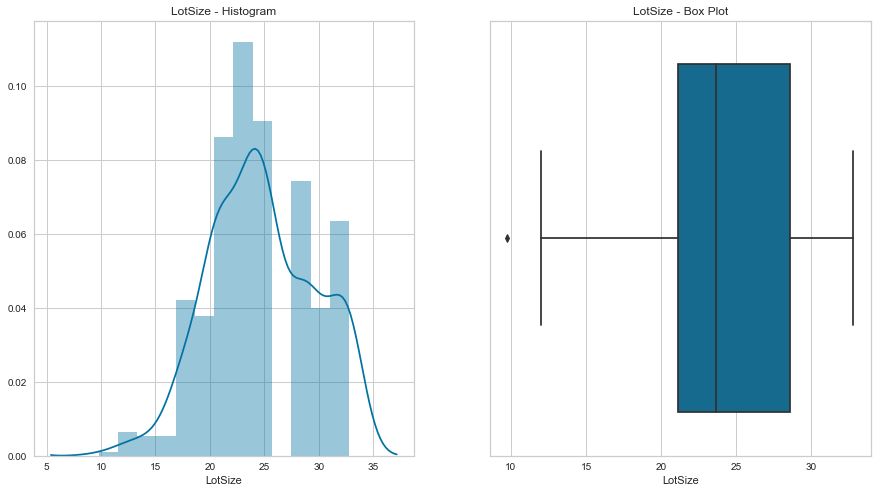

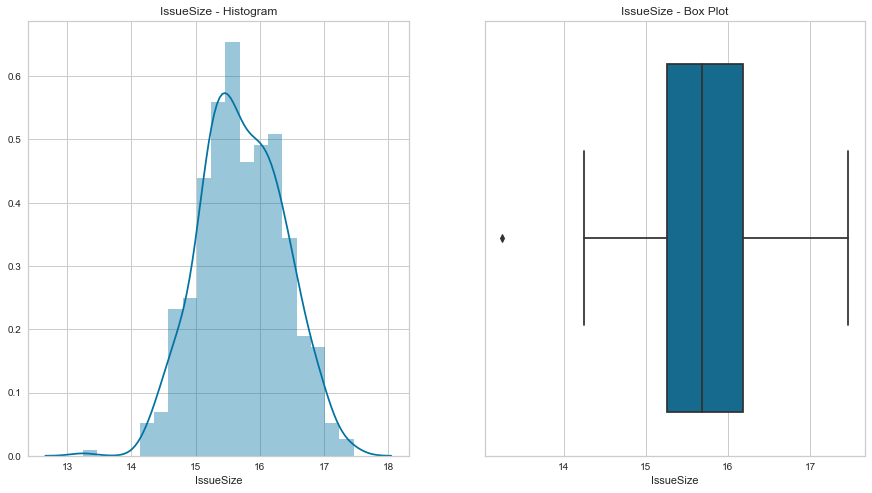

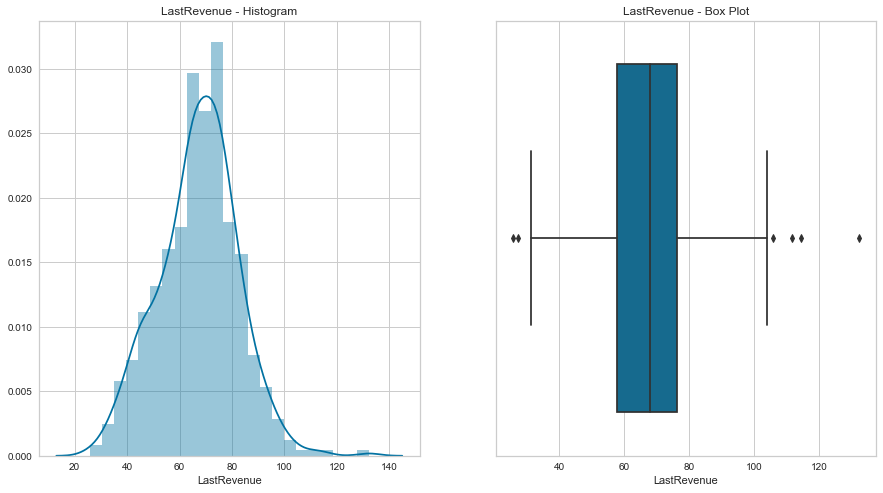

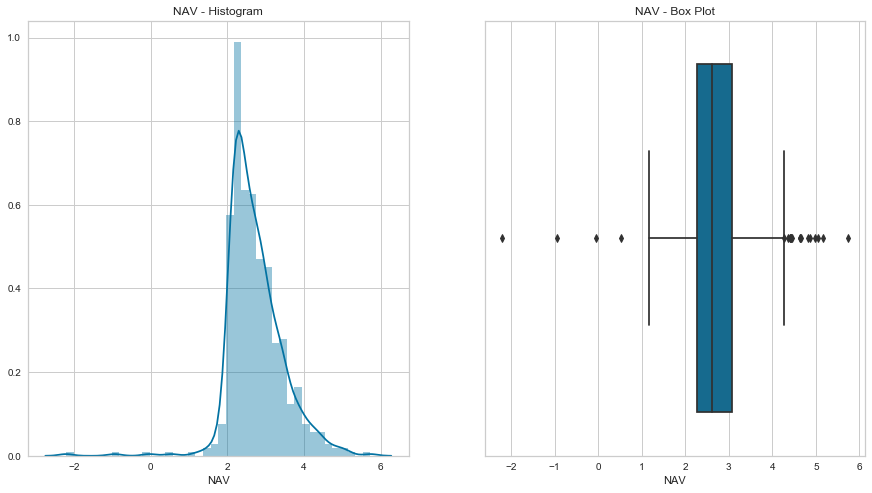

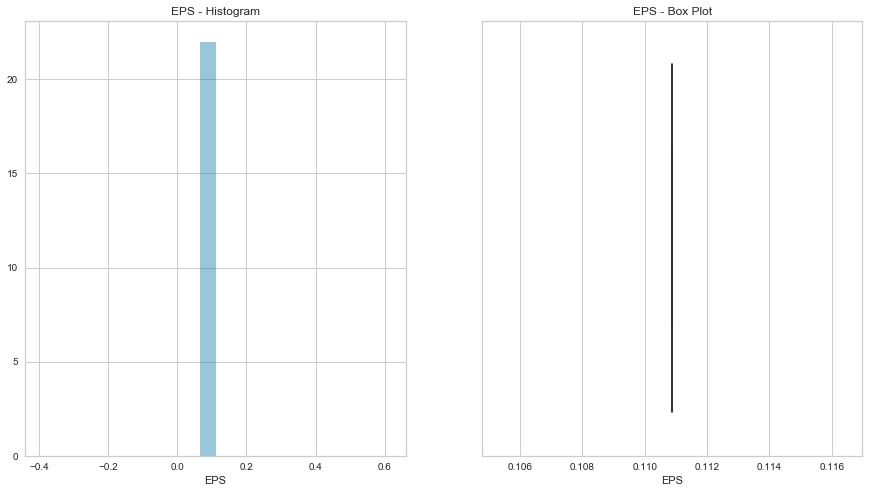

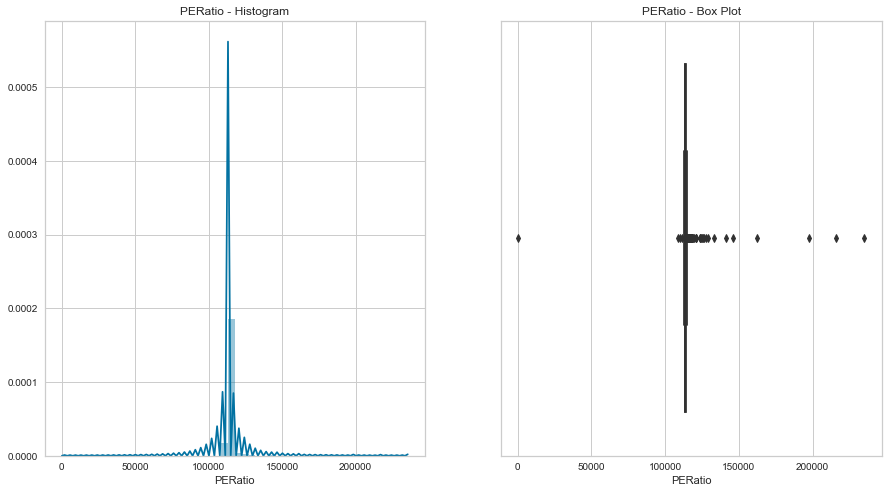

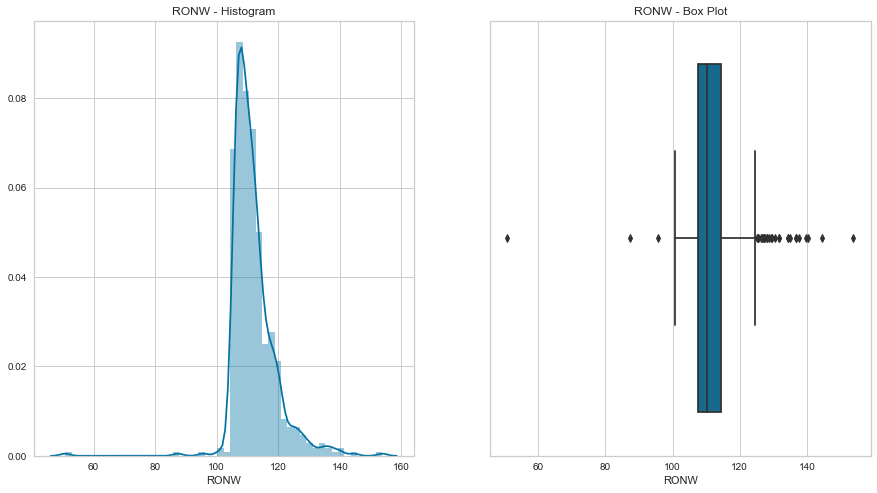

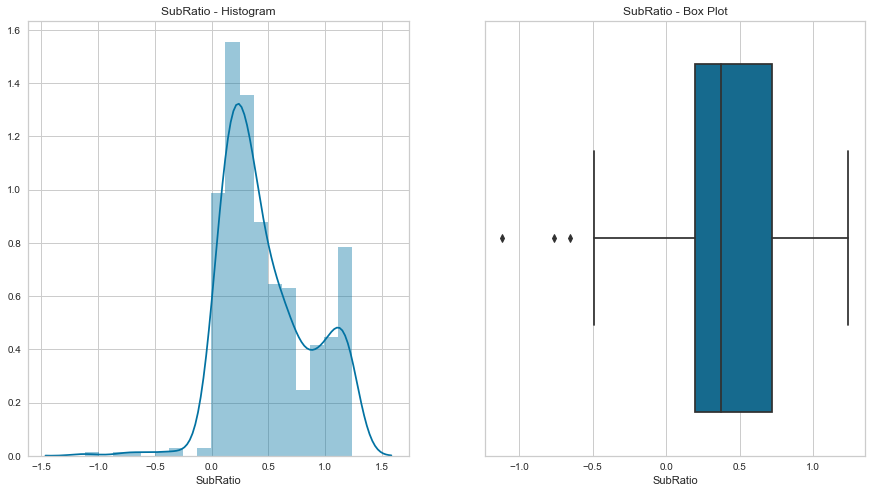

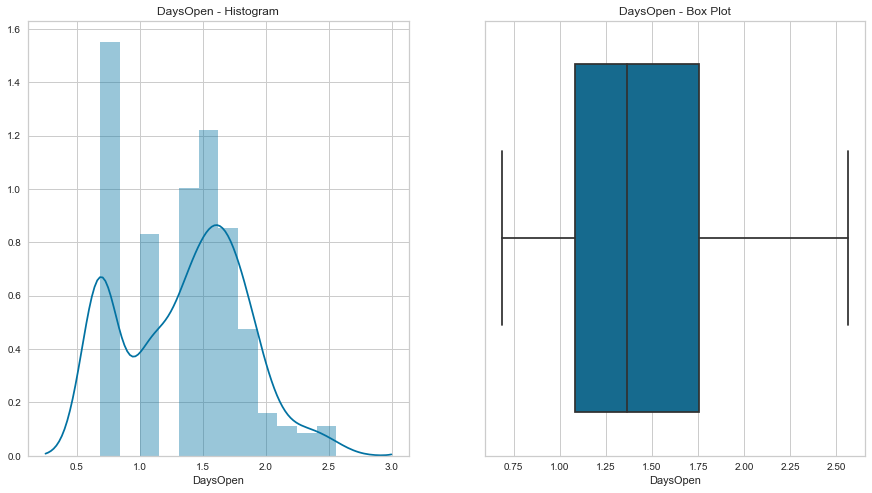

In [81]:
plotBoxPlotFrame(smeDataBoxCox, colsNumeric)

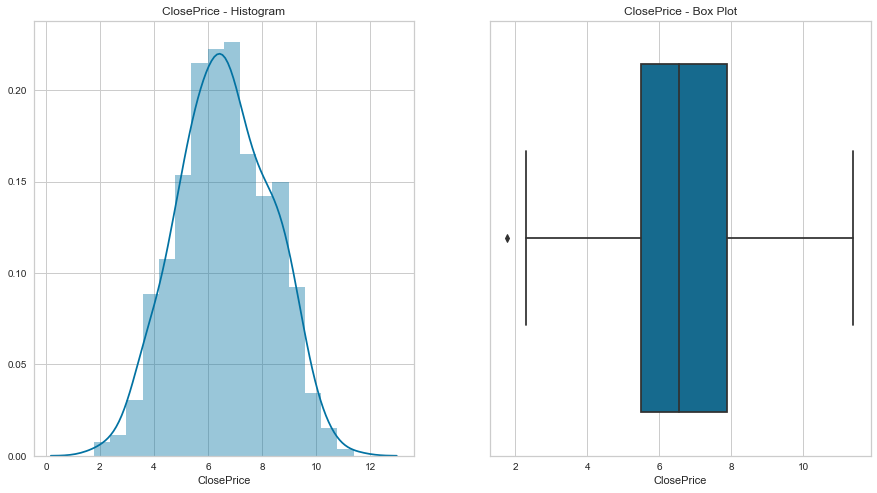

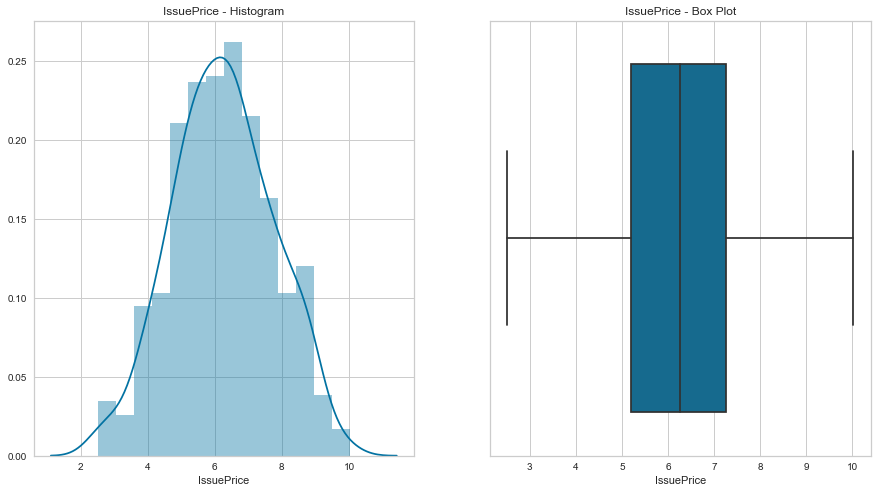

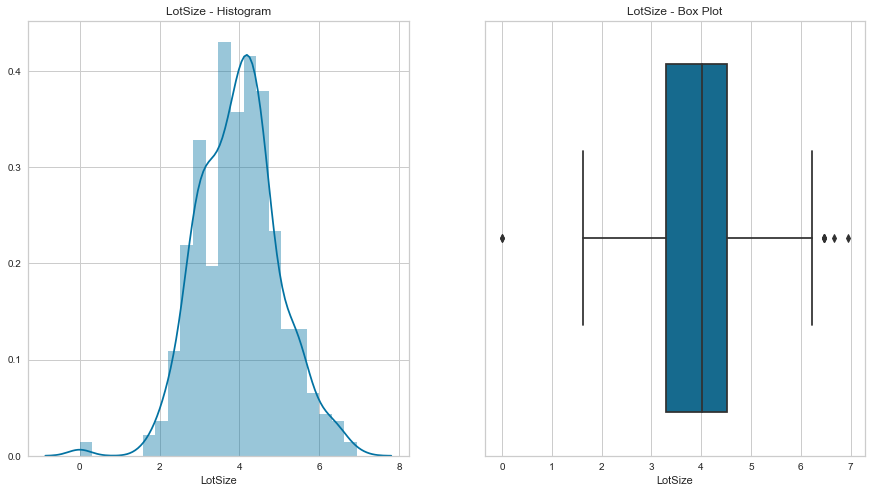

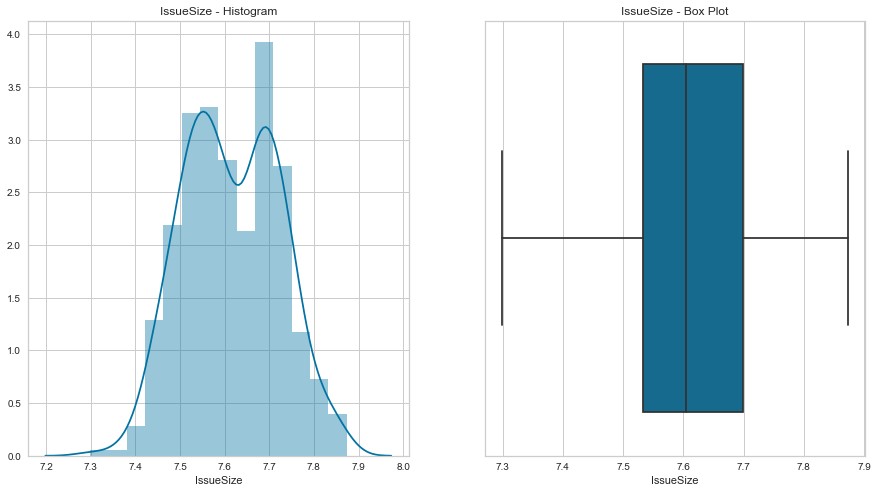

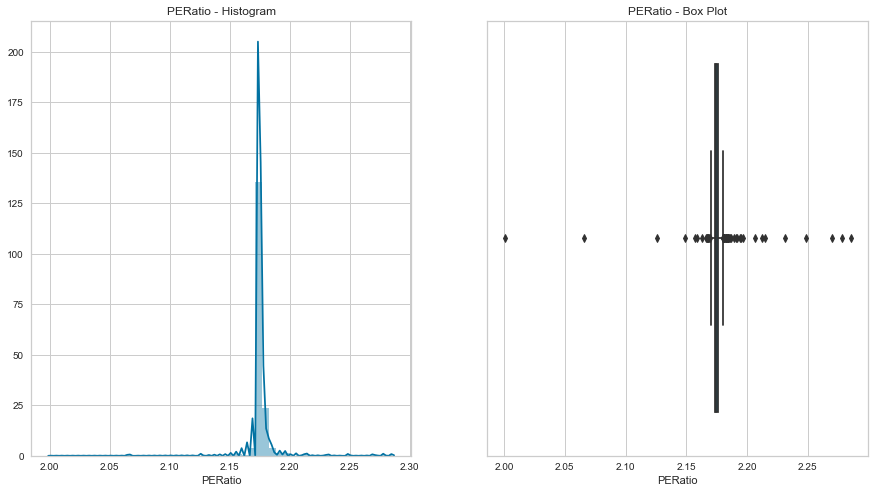

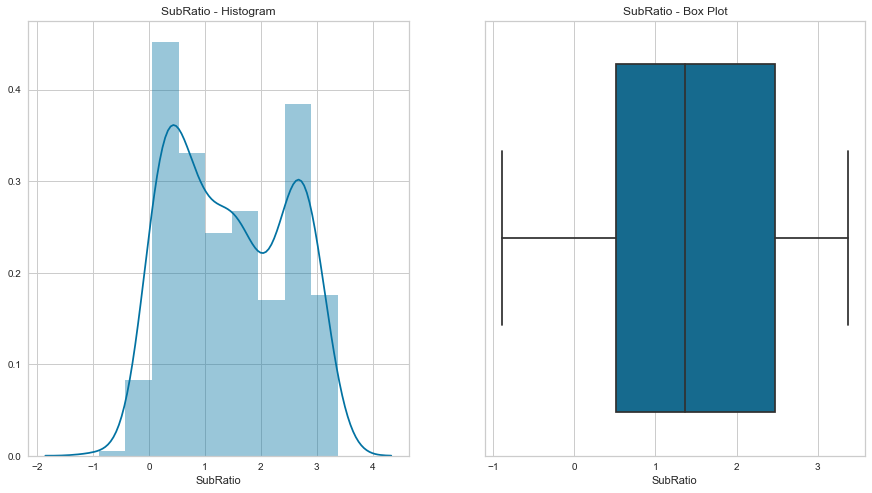

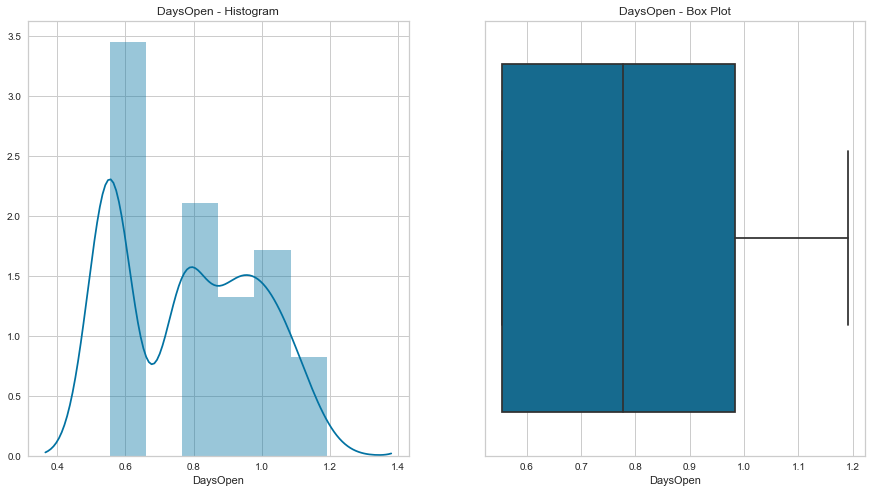

In [82]:
plotBoxPlotFrame(mainDataBoxCox, colsNumeric)

In [9]:
vifCols = colsToCorrelate.copy()
vifCols.remove('ClosePrice')
vifCols.append('BBIIPO')
vifCols.remove('EPS')
vifCols.remove('IssueSize')
vifCols.remove('DaysOpen')
vifCols

['IssuePrice',
 'LotSize',
 'LastRevenue',
 'NAV',
 'PERatio',
 'RONW',
 'SubRatio',
 'BBIIPO']

In [96]:
#Linear Regression - K Fold - SME IPO
folds = KFold(n_splits = 5)
lmResList = list()
count = 0
for trnIx, tstIx in folds.split(smeDataBoxCox):
    xTrn = smeDataBoxCox.iloc[trnIx,:]
    yTrn = smeDataBoxCox.iloc[trnIx,:]['ClosePrice']
    xTst = smeDataBoxCox.iloc[tstIx,:]
    yTst = smeDataBoxCox.iloc[tstIx,:]['ClosePrice']
    linModel = fsm.ols('ClosePrice ~ LotSize + IssuePrice + RONW + NAV + PERatio + SubRatio + BBIIPO', data = xTrn).fit()
    lm_aov_table = sm.stats.anova_lm(linModel, typ=2)
    predictions = linModel.predict(xTst)
    predictionsTrain = linModel.predict(xTrn)
    lm_MSE = mean_squared_error(yTst, predictions)
    lm_RMSE = math.sqrt(lm_MSE)
    lm_MAE = mean_absolute_error(yTst, predictions)
    lm_MAPE = lm_MAE/len(predictions)
    lm_vif = getVif(xTrn[vifCols])
    lm_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    lm_RMSE_train = math.sqrt(lm_MSE_train)
    lm_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    lm_MAPE_train = lm_MAE_train/len(predictionsTrain)
    lm_vif = getVif(xTrn[vifCols])
    lmResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': linModel,
        'AOVTable': lm_aov_table,
        'vif': lm_vif,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': lm_MSE,
            'RMSE': lm_RMSE,
            'MAE': lm_MAE,
            'MAPE': lm_MAPE,
            'R2': linModel.rsquared,
            'AdjustedR2': linModel.rsquared_adj
        },
        'metricsTrain': {
            'MSE': lm_MSE_train,
            'RMSE': lm_RMSE_train,
            'MAE': lm_MAE_train,
            'MAPE': lm_MAPE_train
        }
    })
    print("------------------------------Linear Regression Response - START ({})------------------------".format(count))
    count+=1
    print(linModel.summary())
    print(lm_aov_table)
    
    print('Mean Squared Error(Train): ', lm_MSE)
    print('Root Mean Squared Error(Train): ', lm_RMSE)
    print('Mean Absolute Error(Train): ', lm_MAE)
    print('Mean Absolute Percentage Error(Train): ', lm_MAPE)
    
    print('Mean Squared Error(Test): ', lm_MSE)
    print('Root Mean Squared Error(Test): ', lm_RMSE)
    print('Mean Absolute Error(Test): ', lm_MAE)
    print('Mean Absolute Percentage Error(Test): ', lm_MAPE)
    
    print('vif', lm_vif)
    print("------------------------------Linear Regression Response - END --------------------------")

lmResListSorted = sorted(lmResList, key = lambda i: i['metrics']['MAPE'])

------------------------------Linear Regression Response - START (0)------------------------
                            OLS Regression Results                            
Dep. Variable:             ClosePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     867.4
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.06e-241
Time:                        13:32:40   Log-Likelihood:                 298.71
No. Observations:                 419   AIC:                            -581.4
Df Residuals:                     411   BIC:                            -549.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

------------------------------Linear Regression Response - START (4)------------------------
                            OLS Regression Results                            
Dep. Variable:             ClosePrice   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2360.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:32:41   Log-Likelihood:                 534.43
No. Observations:                 420   AIC:                            -1053.
Df Residuals:                     412   BIC:                            -1021.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [97]:
lmResListSorted[0]['model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             ClosePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     867.4
Date:                Sun, 22 Mar 2020   Prob (F-statistic):          1.06e-241
Time:                        13:32:42   Log-Likelihood:                 298.71
No. Observations:                 419   AIC:                            -581.4
Df Residuals:                     411   BIC:                            -549.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6538      0.336     -1.944      0.053      -1.315       0.007
LotSize        0.0069      0.006      1.219      0.223      -0.004       0.018
IssuePrice     1.1448      0.067     17.058      0.000       1.013       1.277
RONW           0.0010      0.001      1.053      0.293      -0.001       0.003
NAV            0.0206      0.008      2.419      0.016       0.004       0.037
PERatio      7.67e-07   5.52e-07      1.390      0.165   -3.18e-07    1.85e-06
SubRatio       0.0453      0.015      2.959      0.003       0.015       0.075
BBIIPO         0.0123      0.018      0.666      0.506      -0.024       0.049
==============================================================================
Omnibus:                      460.118   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31352.361
Skew:                           4.829   Prob(JB):                         0.00
Kurtosis:                      44.262   Cond. No.                     6.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

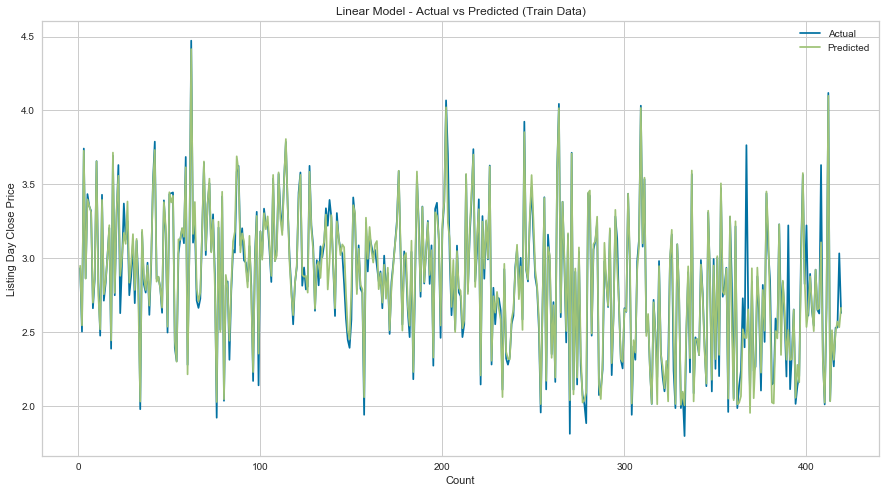

In [98]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictionsTrain'])+1)]
y1 = lmResult['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

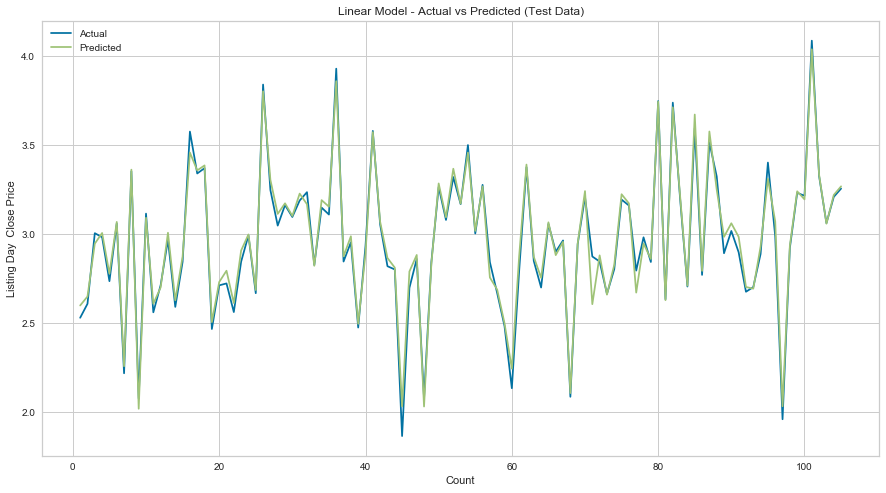

In [99]:
lmResult = lmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(lmResult['predictions'])+1)]
y1 = lmResult['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = lmResult['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [100]:
lmResult['metrics']

{'MSE': 0.002972396044165734,
 'RMSE': 0.05451968492357356,
 'MAE': 0.0390294739342037,
 'MAPE': 0.00037170927556384476,
 'R2': 0.936601194500716,
 'AdjustedR2': 0.9355214094922124}

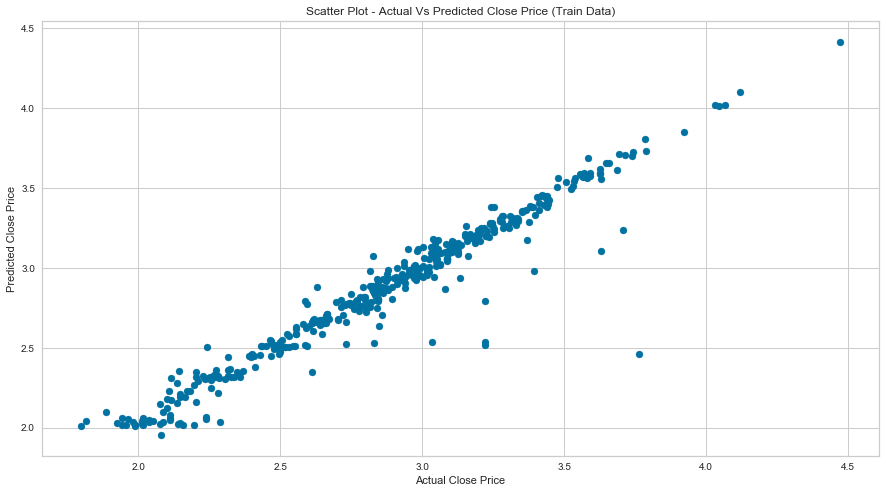

In [101]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Train Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(lmResult['yTrain'],lmResult['model'].fittedvalues)
plt.show()

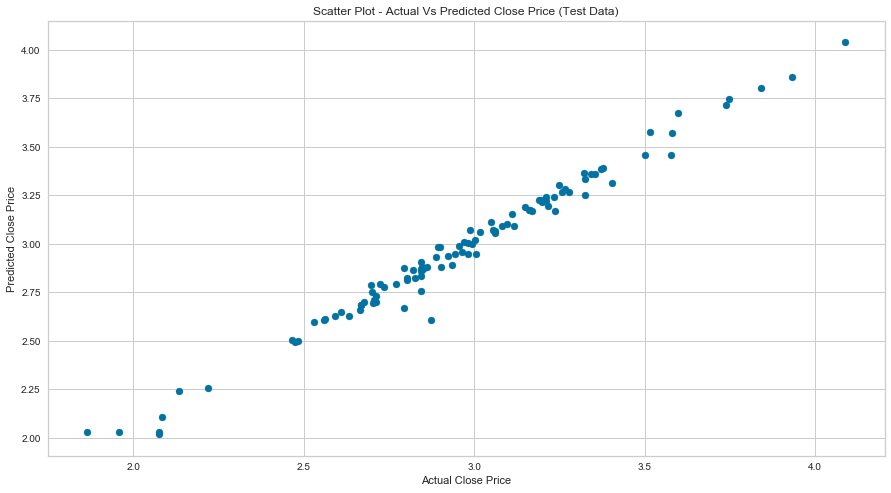

In [102]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Test Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(y1,y2)
plt.show()

In [103]:
fig, ax = plt.subplots(figsize=(15,8))
sns.residplot(lmResult['model'].fittedvalues, lmResult['model'].resid, lowess=True, color="g")

In [104]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(lmResult['model'].resid)

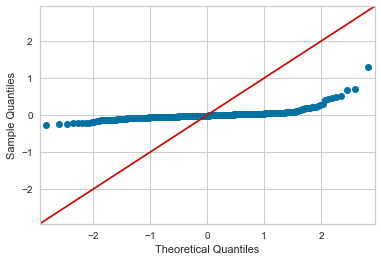

In [105]:
sm.qqplot(lmResult['model'].resid, line ='45')

In [106]:
sp.stats.shapiro(lmResult['model'].resid)

(0.6357190608978271, 7.2305109661226e-29)

In [ ]:
mainData.columns

In [ ]:
mainVifCols = ['LotSize', 'IssuePrice', 'IssueSize', 'LastRevenue','NAV','PERatio','RONW','SubRatio']
# mainVifCols = ['LotSize', 'IssuePrice', 'IssueSize', 'LastRevenue','NAV','PERatio','RONW','DaysOpen','SubRatio','BBIIPO']

In [ ]:
#Linear Regression - K Fold - MainBoard IPO
folds = KFold(n_splits = 5)
mainLmResList = list()
count = 0
for trnIx, tstIx in folds.split(mainData):
    xTrn = mainData.iloc[trnIx,:]
    yTrn = mainData.iloc[trnIx,:]['ClosePrice']
    xTst = mainData.iloc[tstIx,:]
    yTst = mainData.iloc[tstIx,:]['ClosePrice']
    linModel = fsm.ols('ClosePrice ~ IssuePrice + NAV + SubRatio', data = xTrn).fit()
    lm_aov_table = sm.stats.anova_lm(linModel, typ=2)
    predictions = linModel.predict(xTst)
    predictionsTrain = linModel.predict(xTrn)
    lm_MSE = mean_squared_error(yTst, predictions)
    lm_RMSE = math.sqrt(lm_MSE)
    lm_MAE = mean_absolute_error(yTst, predictions)
    lm_MAPE = lm_MAE/len(predictions)
    lm_vif = getVif(xTrn[vifCols])
    lm_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    lm_RMSE_train = math.sqrt(lm_MSE_train)
    lm_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    lm_MAPE_train = lm_MAE_train/len(predictionsTrain)
    lm_vif = getVif(xTrn[mainVifCols])
    mainLmResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': linModel,
        'AOVTable': lm_aov_table,
        'vif': lm_vif,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': lm_MSE,
            'RMSE': lm_RMSE,
            'MAE': lm_MAE,
            'MAPE': lm_MAPE,
            'R2': linModel.rsquared,
            'AdjustedR2': linModel.rsquared_adj
        },
        'metricsTrain': {
            'MSE': lm_MSE_train,
            'RMSE': lm_RMSE_train,
            'MAE': lm_MAE_train,
            'MAPE': lm_MAPE_train
        }
    })
    print("------------------------------Linear Regression Response - START ({})------------------------".format(count))
    count+=1
    print(linModel.summary())
    print(lm_aov_table)
    
    print('Mean Squared Error(Train): ', lm_MSE)
    print('Root Mean Squared Error(Train): ', lm_RMSE)
    print('Mean Absolute Error(Train): ', lm_MAE)
    print('Mean Absolute Percentage Error(Train): ', lm_MAPE)
    
    print('Mean Squared Error(Test): ', lm_MSE)
    print('Root Mean Squared Error(Test): ', lm_RMSE)
    print('Mean Absolute Error(Test): ', lm_MAE)
    print('Mean Absolute Percentage Error(Test): ', lm_MAPE)
    
    print('vif', lm_vif)
    print("------------------------------Linear Regression Response - END --------------------------")

mainLmResListSorted = sorted(mainLmResList, key = lambda i: i['metrics']['MAPE'])

In [ ]:
mainLmResListSorted[0]['model'].summary()

In [ ]:
mainLmResult = mainLmResListSorted[0]

fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(mainLmResult['predictionsTrain'])+1)]
y1 = mainLmResult['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = mainLmResult['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(mainLmResult['predictions'])+1)]
y1 = mainLmResult['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = mainLmResult['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
mainLmResult['metrics']

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Train Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(lmResult['yTrain'],lmResult['model'].fittedvalues)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
plt.title('Scatter Plot - Actual Vs Predicted Close Price (Test Data)')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.scatter(y1,y2)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
sns.residplot(lmResult['model'].fittedvalues, lmResult['model'].resid, lowess=True, color="g")

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
sns.distplot(lmResult['model'].resid)

In [ ]:
sm.qqplot(lmResult['model'].resid, line ='45')

In [ ]:
sp.stats.shapiro(lmResult['model'].resid)

In [8]:
colsToRemove = ['IssueComp', 'Exchange', 'Open', 'Close', 'ClosePrice', 'Shares', 'IsMain', 'EPS', 'FPIIPO', 'FaceValue']
colsToInclude = smeData.columns.difference(colsToRemove)
colsToInclude

Index(['BBIIPO', 'DaysOpen', 'IssuePrice', 'IssueSize', 'LastRevenue',
       'LotSize', 'NAV', 'PERatio', 'RONW', 'SubRatio'],
      dtype='object')

In [47]:
colsNorm = list(colsToInclude)
colsNorm.append('ClosePrice')
smeNormData = pd.DataFrame(PP.MinMaxScaler().fit_transform(smeData[colsNorm]), columns = colsNorm)
mainNormData = pd.DataFrame(PP.MinMaxScaler().fit_transform(mainData[colsNorm]), columns = colsNorm)

In [60]:
#Neural Networks

folds = KFold(n_splits = 5)
smeNNResList = list()

for trnIx, tstIx in folds.split(smeNormData):
    xTrn = smeNormData.iloc[trnIx,:][colsToInclude]
    yTrn = smeData.iloc[trnIx,:]['ClosePrice']
    xTst = smeNormData.iloc[tstIx,:][colsToInclude]
    yTst = smeData.iloc[tstIx,:]['ClosePrice']
    xLen = xTrn.shape[1]
    iLen = xLen*20
    nnModel = Sequential()
    nnModel.add(Dense(round(iLen), input_shape=(xLen,), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(iLen/2), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(iLen/3), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(1, kernel_initializer='normal'))
    nnModel.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping_monitor = EarlyStopping(patience=50)
    nnModel.fit(xTrn, yTrn, validation_split = 0.2, epochs=1000, callbacks=[early_stopping_monitor])
    predictions = nnModel.predict(xTst)
    nn_MSE = mean_squared_error(yTst, predictions)
    nn_RMSE = math.sqrt(nn_MSE)
    nn_MAE = mean_absolute_error(yTst, predictions)
    nn_MAPE = nn_MAE/len(predictions)
    predictionsTrain = nnModel.predict(xTrn)
    nn_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    nn_RMSE_train = math.sqrt(nn_MSE_train)
    nn_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    nn_MAPE_train = nn_MAE_train/len(predictionsTrain)
    smeNNResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': nnModel,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': nn_MSE,
            'RMSE': nn_RMSE,
            'MAE': nn_MAE,
            'MAPE': nn_MAPE
        },
        'metricsTrain': {
            'MSE': nn_MSE_train,
            'RMSE': nn_RMSE_train,
            'MAE': nn_MAE_train,
            'MAPE': nn_MAPE_train
        }        
    })

Train on 335 samples, validate on 84 samples
Epoch 1/1000
335/335 [==============================] - 0s 583us/step - loss: 7782.8031 - val_loss: 4220.3121
Epoch 2/1000
335/335 [==============================] - 0s 91us/step - loss: 7750.1690 - val_loss: 4173.7712
Epoch 3/1000
335/335 [==============================] - 0s 88us/step - loss: 7619.1309 - val_loss: 4004.6464
Epoch 4/1000
335/335 [==============================] - 0s 123us/step - loss: 7179.3181 - val_loss: 3537.3751
Epoch 5/1000
335/335 [==============================] - 0s 100us/step - loss: 6181.0452 - val_loss: 2853.8402
Epoch 6/1000
335/335 [==============================] - 0s 92us/step - loss: 4779.8063 - val_loss: 3095.9043
Epoch 7/1000
335/335 [==============================] - 0s 100us/step - loss: 4539.1441 - val_loss: 3353.6166
Epoch 8/1000
335/335 [==============================] - 0s 92us/step - loss: 4281.3835 - val_loss: 2735.4233
Epoch 9/1000
335/335 [==============================] - 0s 91us/step - loss: 41

Epoch 76/1000
335/335 [==============================] - 0s 93us/step - loss: 161.3672 - val_loss: 567.9140
Epoch 77/1000
335/335 [==============================] - 0s 89us/step - loss: 157.9022 - val_loss: 559.7237
Epoch 78/1000
335/335 [==============================] - 0s 89us/step - loss: 155.8784 - val_loss: 561.9144
Epoch 79/1000
335/335 [==============================] - 0s 89us/step - loss: 157.3877 - val_loss: 561.1729
Epoch 80/1000
335/335 [==============================] - 0s 81us/step - loss: 154.6118 - val_loss: 564.5136
Epoch 81/1000
335/335 [==============================] - 0s 79us/step - loss: 152.0081 - val_loss: 556.2693
Epoch 82/1000
335/335 [==============================] - 0s 92us/step - loss: 147.2480 - val_loss: 560.3713
Epoch 83/1000
335/335 [==============================] - 0s 77us/step - loss: 141.8026 - val_loss: 555.7285
Epoch 84/1000
335/335 [==============================] - 0s 86us/step - loss: 140.9479 - val_loss: 556.1684
Epoch 85/1000
335/335 [=====

335/335 [==============================] - 0s 101us/step - loss: 116.4677 - val_loss: 549.5534
Epoch 67/1000
335/335 [==============================] - 0s 109us/step - loss: 112.0322 - val_loss: 538.5783
Epoch 68/1000
335/335 [==============================] - 0s 107us/step - loss: 113.6194 - val_loss: 552.8732
Epoch 69/1000
335/335 [==============================] - 0s 91us/step - loss: 110.4252 - val_loss: 544.3948
Epoch 70/1000
335/335 [==============================] - 0s 115us/step - loss: 108.7001 - val_loss: 543.6082
Epoch 71/1000
335/335 [==============================] - 0s 99us/step - loss: 108.4261 - val_loss: 552.0590
Epoch 72/1000
335/335 [==============================] - 0s 103us/step - loss: 107.5214 - val_loss: 540.9981
Epoch 73/1000
335/335 [==============================] - 0s 89us/step - loss: 106.0960 - val_loss: 555.5417
Epoch 74/1000
335/335 [==============================] - 0s 89us/step - loss: 103.2440 - val_loss: 540.8185
Epoch 75/1000
335/335 [==============

335/335 [==============================] - 0s 95us/step - loss: 101.3808 - val_loss: 547.4707
Epoch 100/1000
335/335 [==============================] - 0s 96us/step - loss: 98.0882 - val_loss: 551.4088
Epoch 101/1000
335/335 [==============================] - 0s 113us/step - loss: 99.0507 - val_loss: 553.5249
Epoch 102/1000
335/335 [==============================] - 0s 99us/step - loss: 97.7838 - val_loss: 551.0101
Epoch 103/1000
335/335 [==============================] - 0s 112us/step - loss: 96.0189 - val_loss: 549.6914
Epoch 104/1000
335/335 [==============================] - 0s 96us/step - loss: 95.1730 - val_loss: 549.8433
Epoch 105/1000
335/335 [==============================] - 0s 114us/step - loss: 94.2329 - val_loss: 553.5540
Epoch 106/1000
335/335 [==============================] - 0s 118us/step - loss: 92.8647 - val_loss: 554.0123
Epoch 107/1000
335/335 [==============================] - 0s 98us/step - loss: 95.8402 - val_loss: 557.0363
Epoch 108/1000
335/335 [==============

Epoch 12/1000
335/335 [==============================] - 0s 99us/step - loss: 3620.8102 - val_loss: 2406.7181
Epoch 13/1000
335/335 [==============================] - 0s 94us/step - loss: 3514.7995 - val_loss: 2348.2945
Epoch 14/1000
335/335 [==============================] - 0s 102us/step - loss: 3346.6915 - val_loss: 2176.1991
Epoch 15/1000
335/335 [==============================] - 0s 97us/step - loss: 3214.4915 - val_loss: 2083.5315
Epoch 16/1000
335/335 [==============================] - 0s 102us/step - loss: 3009.8711 - val_loss: 1916.3681
Epoch 17/1000
335/335 [==============================] - 0s 104us/step - loss: 2831.7703 - val_loss: 1803.0444
Epoch 18/1000
335/335 [==============================] - 0s 98us/step - loss: 2643.6251 - val_loss: 1671.0576
Epoch 19/1000
335/335 [==============================] - 0s 112us/step - loss: 2462.9415 - val_loss: 1544.7908
Epoch 20/1000
335/335 [==============================] - 0s 104us/step - loss: 2223.3175 - val_loss: 1476.7738
Epoch

335/335 [==============================] - 0s 111us/step - loss: 101.8008 - val_loss: 626.1101
Epoch 88/1000
335/335 [==============================] - 0s 106us/step - loss: 99.7512 - val_loss: 620.3479
Epoch 89/1000
335/335 [==============================] - 0s 120us/step - loss: 98.2867 - val_loss: 613.3355
Epoch 90/1000
335/335 [==============================] - 0s 99us/step - loss: 95.0172 - val_loss: 623.5794
Epoch 91/1000
335/335 [==============================] - 0s 94us/step - loss: 93.6946 - val_loss: 615.1700
Epoch 92/1000
335/335 [==============================] - 0s 99us/step - loss: 93.0893 - val_loss: 613.1033
Epoch 93/1000
335/335 [==============================] - 0s 95us/step - loss: 90.3294 - val_loss: 618.5007
Epoch 94/1000
335/335 [==============================] - 0s 84us/step - loss: 88.5140 - val_loss: 609.6089
Epoch 95/1000
335/335 [==============================] - 0s 119us/step - loss: 87.5525 - val_loss: 608.7007
Epoch 96/1000
335/335 [=======================

336/336 [==============================] - 0s 100us/step - loss: 3096.7572 - val_loss: 2492.3310
Epoch 15/1000
336/336 [==============================] - 0s 101us/step - loss: 2923.7811 - val_loss: 2286.4652
Epoch 16/1000
336/336 [==============================] - 0s 88us/step - loss: 2703.4583 - val_loss: 2113.2078
Epoch 17/1000
336/336 [==============================] - 0s 89us/step - loss: 2558.3871 - val_loss: 1867.2285
Epoch 18/1000
336/336 [==============================] - 0s 91us/step - loss: 2301.8676 - val_loss: 1747.5811
Epoch 19/1000
336/336 [==============================] - 0s 105us/step - loss: 2084.9484 - val_loss: 1553.6932
Epoch 20/1000
336/336 [==============================] - 0s 79us/step - loss: 1867.2133 - val_loss: 1470.7789
Epoch 21/1000
336/336 [==============================] - 0s 86us/step - loss: 1683.2093 - val_loss: 1300.2772
Epoch 22/1000
336/336 [==============================] - 0s 91us/step - loss: 1585.3816 - val_loss: 1220.6236
Epoch 23/1000
336/336

Epoch 165/1000
336/336 [==============================] - 0s 98us/step - loss: 86.8469 - val_loss: 82.0962
Epoch 166/1000
336/336 [==============================] - 0s 93us/step - loss: 85.9830 - val_loss: 85.6274
Epoch 167/1000
336/336 [==============================] - 0s 98us/step - loss: 85.0686 - val_loss: 84.5054
Epoch 168/1000
336/336 [==============================] - 0s 102us/step - loss: 85.1022 - val_loss: 80.0326
Epoch 169/1000
336/336 [==============================] - 0s 100us/step - loss: 84.8545 - val_loss: 87.0581
Epoch 170/1000
336/336 [==============================] - 0s 111us/step - loss: 85.7030 - val_loss: 84.4808
Epoch 171/1000
336/336 [==============================] - 0s 100us/step - loss: 88.0712 - val_loss: 79.2200
Epoch 172/1000
336/336 [==============================] - 0s 106us/step - loss: 86.1898 - val_loss: 82.0753
Epoch 173/1000
336/336 [==============================] - 0s 100us/step - loss: 85.3552 - val_loss: 87.2683
Epoch 174/1000
336/336 [=======

336/336 [==============================] - 0s 102us/step - loss: 55.7940 - val_loss: 61.3288
Epoch 318/1000
336/336 [==============================] - 0s 106us/step - loss: 56.8698 - val_loss: 65.0044
Epoch 319/1000
336/336 [==============================] - 0s 102us/step - loss: 55.5069 - val_loss: 58.8136
Epoch 320/1000
336/336 [==============================] - 0s 83us/step - loss: 55.3469 - val_loss: 61.4128
Epoch 321/1000
336/336 [==============================] - 0s 102us/step - loss: 57.1104 - val_loss: 66.5694
Epoch 322/1000
336/336 [==============================] - 0s 112us/step - loss: 60.9893 - val_loss: 59.8147
Epoch 323/1000
336/336 [==============================] - 0s 102us/step - loss: 55.4249 - val_loss: 61.6960
Epoch 324/1000
336/336 [==============================] - 0s 138us/step - loss: 54.1809 - val_loss: 61.9687
Epoch 325/1000
336/336 [==============================] - 0s 126us/step - loss: 56.8698 - val_loss: 61.3192
Epoch 326/1000
336/336 [====================

In [61]:
smeErrData = [[x['metrics']['MSE'], x['metrics']['RMSE'], x['metrics']['MAE'], x['metrics']['MAPE']] for x in smeNNResList]
smeErrFrame = pd.DataFrame(data = smeErrData, columns = ['MSE', 'RMSE', 'MAE', 'MAPE'])
smeErrFrame

MSE       RMSE       MAE      MAPE
0   46.289262   6.803621  5.065426  0.048242
1   92.581505   9.621928  6.341249  0.060393
2  363.220466  19.058344  8.691625  0.082777
3  222.552949  14.918209  6.409000  0.061038
4  510.176652  22.587090  8.281209  0.079627

In [62]:
smeNNResListSorted = sorted(smeNNResList, key = lambda i: i['metrics']['MAPE'])
smeNNLowErr = smeNNResListSorted[0]

In [63]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(smeNNLowErr['predictionsTrain'])+1)]
y1 = smeNNLowErr['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = smeNNLowErr['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

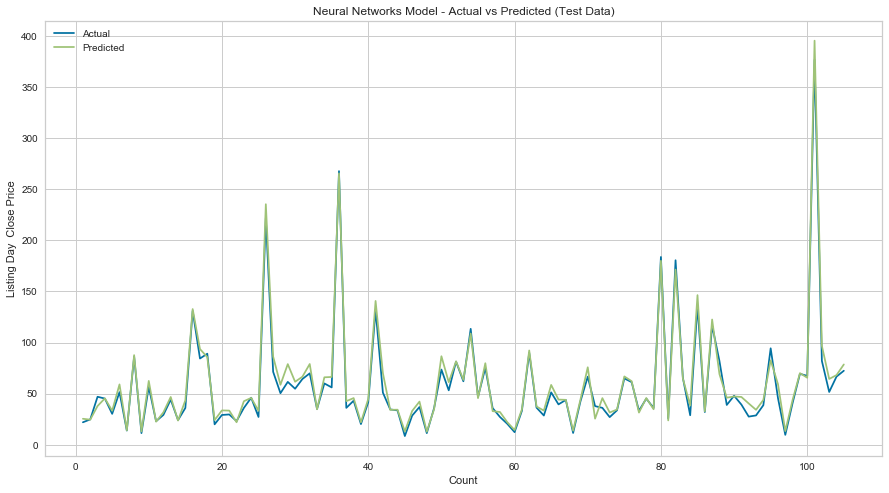

In [64]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(smeNNLowErr['predictions'])+1)]
y1 = smeNNLowErr['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = smeNNLowErr['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Neural Networks Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [70]:
#Neural Networks

folds = KFold(n_splits = 5)
mainNNResList = list()

for trnIx, tstIx in folds.split(mainNormData):
    xTrn = mainNormData.iloc[trnIx,:][colsToInclude]
    yTrn = mainData.iloc[trnIx,:]['ClosePrice']
    xTst = mainNormData.iloc[tstIx,:][colsToInclude]
    yTst = mainData.iloc[tstIx,:]['ClosePrice']
    xLen = xTrn.shape[1]
    iLen = xLen*20
    nnModel = Sequential()
    nnModel.add(Dense(round(iLen), input_shape=(xLen,), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(iLen/2), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(round(iLen/3), kernel_initializer='normal', activation='relu'))
    nnModel.add(Dense(1, kernel_initializer='normal'))
    nnModel.compile(loss='mean_squared_error', optimizer='adam')
    early_stopping_monitor = EarlyStopping(patience=10)
    nnModel.fit(xTrn, yTrn, validation_split = 0.2, epochs=1000, callbacks=[early_stopping_monitor])
    predictions = nnModel.predict(xTst)
    nn_MSE = mean_squared_error(yTst, predictions)
    nn_RMSE = math.sqrt(nn_MSE)
    nn_MAE = mean_absolute_error(yTst, predictions)
    nn_MAPE = nn_MAE/len(predictions)
    predictionsTrain = nnModel.predict(xTrn)
    nn_MSE_train = mean_squared_error(yTrn, predictionsTrain)
    nn_RMSE_train = math.sqrt(nn_MSE_train)
    nn_MAE_train = mean_absolute_error(yTrn, predictionsTrain)
    nn_MAPE_train = nn_MAE_train/len(predictionsTrain)
    mainNNResList.append({
        'trainIndices': trnIx,
        'testIndices': tstIx,
        'model': nnModel,
        'xTrain': xTrn,
        'yTrain': yTrn,
        'xTest': xTst,
        'yTest': yTst,
        'predictions': predictions,
        'predictionsTrain': predictionsTrain,
        'metrics': {
            'MSE': nn_MSE,
            'RMSE': nn_RMSE,
            'MAE': nn_MAE,
            'MAPE': nn_MAPE
        },
        'metricsTrain': {
            'MSE': nn_MSE_train,
            'RMSE': nn_RMSE_train,
            'MAE': nn_MAE_train,
            'MAPE': nn_MAPE_train
        }        
    })

Train on 277 samples, validate on 70 samples
Epoch 1/1000
277/277 [==============================] - 0s 675us/step - loss: 142484.8774 - val_loss: 80169.1354
Epoch 2/1000
277/277 [==============================] - 0s 114us/step - loss: 142407.7699 - val_loss: 80049.7360
Epoch 3/1000
277/277 [==============================] - 0s 101us/step - loss: 142141.6671 - val_loss: 79654.2919
Epoch 4/1000
277/277 [==============================] - 0s 111us/step - loss: 141310.7130 - val_loss: 78558.2732
Epoch 5/1000
277/277 [==============================] - 0s 99us/step - loss: 139152.3884 - val_loss: 76007.0526
Epoch 6/1000
277/277 [==============================] - 0s 120us/step - loss: 134295.8527 - val_loss: 70714.5295
Epoch 7/1000
277/277 [==============================] - 0s 116us/step - loss: 125163.3659 - val_loss: 61419.4576
Epoch 8/1000
277/277 [==============================] - 0s 100us/step - loss: 108818.7694 - val_loss: 48965.9797
Epoch 9/1000
277/277 [==============================

Epoch 74/1000
277/277 [==============================] - 0s 97us/step - loss: 4255.5785 - val_loss: 5593.2736
Epoch 75/1000
277/277 [==============================] - 0s 96us/step - loss: 4198.1943 - val_loss: 5222.7755
Epoch 76/1000
277/277 [==============================] - 0s 115us/step - loss: 4201.9920 - val_loss: 5322.6578
Epoch 77/1000
277/277 [==============================] - 0s 120us/step - loss: 4138.1127 - val_loss: 5493.5750
Epoch 78/1000
277/277 [==============================] - 0s 109us/step - loss: 4113.8871 - val_loss: 5460.5683
Train on 277 samples, validate on 70 samples
Epoch 1/1000
277/277 [==============================] - 0s 715us/step - loss: 257935.3828 - val_loss: 80171.0396
Epoch 2/1000
277/277 [==============================] - 0s 117us/step - loss: 257828.1450 - val_loss: 80059.7959
Epoch 3/1000
277/277 [==============================] - 0s 106us/step - loss: 257472.9242 - val_loss: 79685.0403
Epoch 4/1000
277/277 [==============================] - 0s 106u

Epoch 10/1000
278/278 [==============================] - 0s 114us/step - loss: 151434.0287 - val_loss: 80077.2512
Epoch 11/1000
278/278 [==============================] - 0s 160us/step - loss: 123925.4076 - val_loss: 70663.7118
Epoch 12/1000
278/278 [==============================] - 0s 119us/step - loss: 113558.0377 - val_loss: 74146.3354
Epoch 13/1000
278/278 [==============================] - 0s 114us/step - loss: 111900.8478 - val_loss: 72221.7984
Epoch 14/1000
278/278 [==============================] - 0s 123us/step - loss: 107839.9391 - val_loss: 67565.6068
Epoch 15/1000
278/278 [==============================] - 0s 103us/step - loss: 104201.6367 - val_loss: 64848.3712
Epoch 16/1000
278/278 [==============================] - 0s 80us/step - loss: 101412.2207 - val_loss: 63203.2696
Epoch 17/1000
278/278 [==============================] - 0s 113us/step - loss: 98012.9417 - val_loss: 61323.4277
Epoch 18/1000
278/278 [==============================] - 0s 88us/step - loss: 94668.9493 -

278/278 [==============================] - 0s 99us/step - loss: 6422.4025 - val_loss: 8632.4806
Epoch 84/1000
278/278 [==============================] - 0s 83us/step - loss: 6332.9864 - val_loss: 8678.2792
Epoch 85/1000
278/278 [==============================] - 0s 90us/step - loss: 6293.3622 - val_loss: 8643.8150
Epoch 86/1000
278/278 [==============================] - 0s 89us/step - loss: 6375.3140 - val_loss: 8449.9539


In [71]:
mainErrData = [[x['metrics']['MSE'], x['metrics']['RMSE'], x['metrics']['MAE'], x['metrics']['MAPE']] for x in mainNNResList]
mainErrFrame = pd.DataFrame(data = smeErrData, columns = ['MSE', 'RMSE', 'MAE', 'MAPE'])
mainErrFrame

MSE       RMSE       MAE      MAPE
0   46.289262   6.803621  5.065426  0.048242
1   92.581505   9.621928  6.341249  0.060393
2  363.220466  19.058344  8.691625  0.082777
3  222.552949  14.918209  6.409000  0.061038
4  510.176652  22.587090  8.281209  0.079627

In [72]:
mainNNResListSorted = sorted(mainNNResList, key = lambda i: i['metrics']['MAPE'])
mainNNLowErr = mainNNResListSorted[0]

In [73]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(mainNNLowErr['predictionsTrain'])+1)]
y1 = mainNNLowErr['yTrain']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = mainNNLowErr['predictionsTrain']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Linear Model - Actual vs Predicted (Train Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [74]:
fig, ax = plt.subplots(figsize=(15,8))
# line 1 points
xAxis = [i for i in range(1,len(mainNNLowErr['predictions'])+1)]
y1 = mainNNLowErr['yTest']
# plotting the line 1 points 
plt.plot(xAxis, y1, label = "Actual")
# line 2 points
y2 = mainNNLowErr['predictions']
# plotting the line 2 points 
plt.plot(xAxis, y2, label = "Predicted")
plt.xlabel('Count')
# Set the y axis label of the current axis.
plt.ylabel('Listing Day  Close Price')
# Set a title of the current axes.
plt.title('Neural Networks Model - Actual vs Predicted (Test Data)')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()